In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [84]:
import sklearn
print(sklearn.__version__)

1.5.2


In [85]:
df= pd.read_csv("Resale flat prices based on registration date from Jan-2017 onwards.csv")

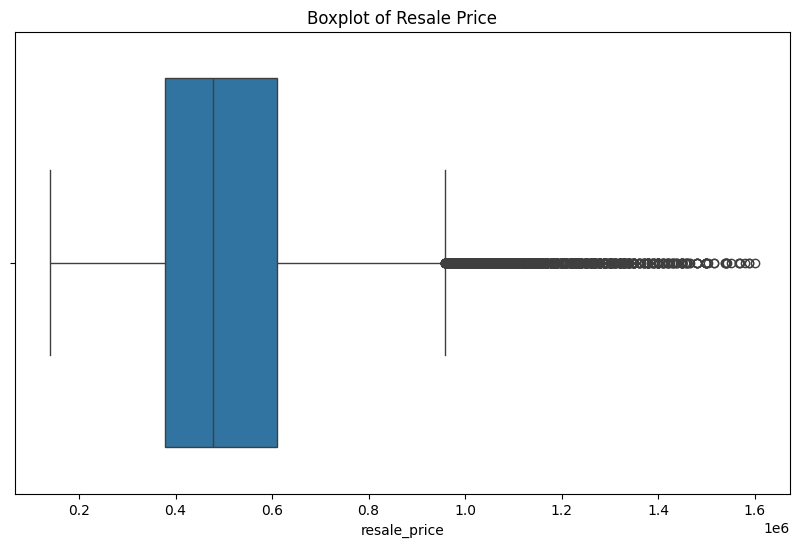

In [86]:
# Step 1: Create a box plot for 'resale_price' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['resale_price'])
plt.title('Boxplot of Resale Price')
plt.show()


Original Data: 198042 rows
Cleaned Data: 194283 rows


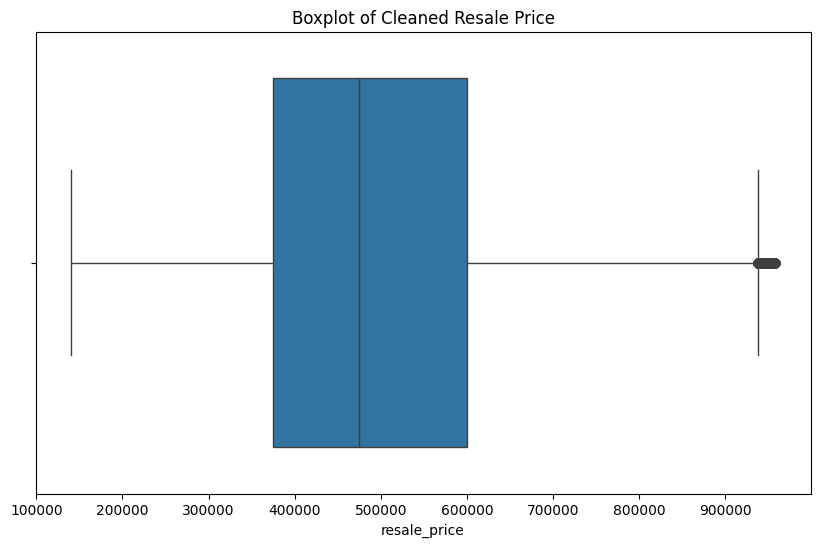

In [87]:
Q1 = df['resale_price'].quantile(0.25)
Q3 = df['resale_price'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df[(df['resale_price'] >= lower_limit) & (df['resale_price'] <= upper_limit)]

# Check how many rows are removed
print(f"Original Data: {len(df)} rows")
print(f"Cleaned Data: {len(df_cleaned)} rows")

# Optionally, plot the cleaned data's box plot again
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['resale_price'])
plt.title('Boxplot of Cleaned Resale Price')
plt.show()

Original Data: 194283 rows
Cleaned Data: 185927 rows


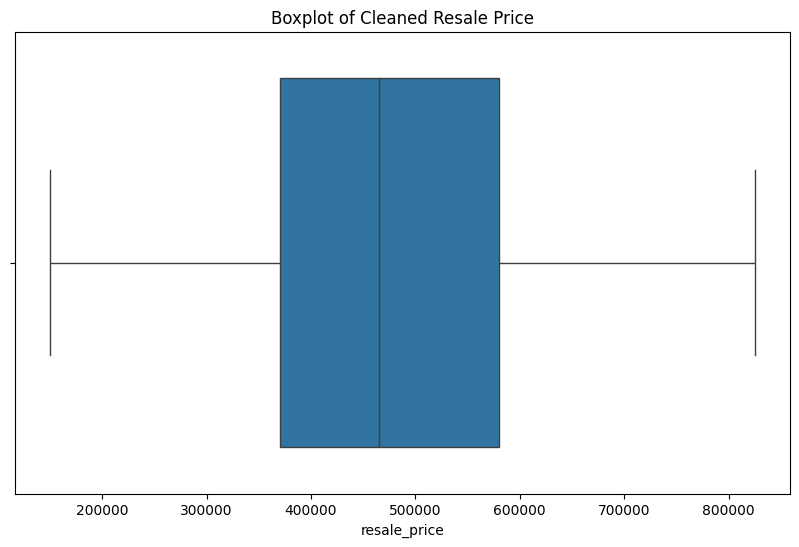

In [88]:
Q1 = df_cleaned['resale_price'].quantile(0.25)
Q3 = df_cleaned['resale_price'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier limits
lower_limit = Q1 - 1 * IQR
upper_limit = Q3 + 1 * IQR

# Remove outliers
df_cleaned2 = df_cleaned[(df_cleaned['resale_price'] >= lower_limit) & (df_cleaned['resale_price'] <= upper_limit)]

# Check how many rows are removed
print(f"Original Data: {len(df_cleaned)} rows")
print(f"Cleaned Data: {len(df_cleaned2)} rows")

# Optionally, plot the cleaned data's box plot again
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned2['resale_price'])
plt.title('Boxplot of Cleaned Resale Price')
plt.show()

In [89]:
# Preprocessing functions
def parse_remaining_lease(lease):
    try:
        years, months = map(int, lease.replace(' years', '').replace(' months', '').split())
        return years * 12 + months
    except:
        return np.nan

def parse_storey_range(storey):
    try:
        start, end = map(int, storey.split(" TO "))
        return (start + end) / 2
    except:
        return np.nan

In [90]:
# Apply preprocessing functions
df['remaining_lease_months'] = df['remaining_lease'].apply(parse_remaining_lease)
df['average_storey'] = df['storey_range'].apply(parse_storey_range)

In [91]:
# Feature Engineering: Adding new features
current_year = 2025  # Adjust based on current year
df['flat_age'] = current_year - df['lease_commence_date']
df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']
df['remaining_lease_ratio'] = df['remaining_lease_months'] / (99 * 12)  # 99 years in months

In [92]:
# Define categorical and numerical columns
categorical_features = ['town', 'flat_type', 'flat_model']
numerical_features = ['floor_area_sqm', 'flat_age', 'remaining_lease_months', 'average_storey', 'price_per_sqm', 'remaining_lease_ratio']


In [93]:
# Split the features and target
X = df[categorical_features + numerical_features]
y = df['resale_price']

In [94]:
# Define column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing numerical data
            ('scaler', StandardScaler())  # Scale numerical data
        ]), numerical_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical data
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One hot encode categorical features
        ]), categorical_features)
    ])

In [95]:
# Define the pipeline with Gradient Boosting Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=25))
])

In [96]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [97]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'flat_age',
                                                   'remaining_lease_months',
                                                   'average_storey',
                                                   'price_per_sqm',
                                                   'remaining_lease_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['town', 'flat_type',
                                                   'flat_model'])])),
                ('model', GradientBoostingRegressor(random_state=25))])

In [98]:
# Make predictions
y_pred = pipeline.predict(X_test)

In [99]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 84989121.18096863
Root Mean Squared Error: 9218.9544516159
R-squared: 0.9973015746900292


In [100]:
# Save the trained model
joblib.dump(pipeline, "gbr_model_with_ohe_and_scaler.pkl") 

print("Model saved successfully!")

Model saved successfully!


In [101]:
print(df.columns)

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'remaining_lease_months',
       'average_storey', 'flat_age', 'price_per_sqm', 'remaining_lease_ratio'],
      dtype='object')


In [102]:
# Get the feature names after one-hot encoding
onehot_column_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)

# Print the resulting column names
print(onehot_column_names)

['town_ANG MO KIO' 'town_BEDOK' 'town_BISHAN' 'town_BUKIT BATOK'
 'town_BUKIT MERAH' 'town_BUKIT PANJANG' 'town_BUKIT TIMAH'
 'town_CENTRAL AREA' 'town_CHOA CHU KANG' 'town_CLEMENTI' 'town_GEYLANG'
 'town_HOUGANG' 'town_JURONG EAST' 'town_JURONG WEST'
 'town_KALLANG/WHAMPOA' 'town_MARINE PARADE' 'town_PASIR RIS'
 'town_PUNGGOL' 'town_QUEENSTOWN' 'town_SEMBAWANG' 'town_SENGKANG'
 'town_SERANGOON' 'town_TAMPINES' 'town_TOA PAYOH' 'town_WOODLANDS'
 'town_YISHUN' 'flat_type_1 ROOM' 'flat_type_2 ROOM' 'flat_type_3 ROOM'
 'flat_type_4 ROOM' 'flat_type_5 ROOM' 'flat_type_EXECUTIVE'
 'flat_type_MULTI-GENERATION' 'flat_model_2-room' 'flat_model_3Gen'
 'flat_model_Adjoined flat' 'flat_model_Apartment' 'flat_model_DBSS'
 'flat_model_Improved' 'flat_model_Improved-Maisonette'
 'flat_model_Maisonette' 'flat_model_Model A'
 'flat_model_Model A-Maisonette' 'flat_model_Model A2'
 'flat_model_Multi Generation' 'flat_model_New Generation'
 'flat_model_Premium Apartment' 'flat_model_Premium Apartment Lof